In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style('whitegrid')

In [7]:
from zadanie1 import read_input, loss

def stats(path):
    P, R, D, W = A = read_input(path)
    
    L_rand = []
    J_rand = np.arange(len(P))
    for i in range(1000):
        np.random.shuffle(J_rand)
        L_rand.append(loss(*A, J_rand))
        
    L_sort = loss(*A, np.argsort(R))
    L_dumb = loss(*A, np.arange(len(P)))
    _, L_good = solve(*A)
    
    return dict(name=path,
                rand_μ=np.mean(L_rand), rand_σ=np.std(L_rand),
                rand_min=np.min(L_rand), rand_max=np.max(L_rand),
                dumb=L_dumb, sort=L_sort, good=L_good)

$$ T_{\text{valid}} = {i : \forall_{i \in T} t1 := max(t, r_j), t2 := t1 + p_j \land \forall_{t \in [t1, t2)} \lnot text{scheduled}(t) $$

In [8]:
from math import inf
from numpy.random import randint, rand
from tqdm.notebook import tqdm

def merge(xs):
    last = -1
    jobs = []
    for x in xs:
        if x == -1:
            continue
        if x != last:
            jobs.append(x)
            last = x
    return jobs

def solve(P, R, D, W):
    N = len(P)
    T = np.arange(N)
    J = []
    norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    S = (D - R)
    M = -1 * np.ones(np.max(D)+1).astype(int)
    MN = len(M)
    μP = np.mean(P)
    μW = np.mean(W)
    σW = np.std(W)
    μS = np.mean(S)
    
    while True:
        assigned = 0
        t = 0
        while t < len(M):
            # Tt = zbiór zadań, które da się wykonać w czasie t, bez opóźnień, biorąc pod uwagę uszeregowane zadania
            # T_valid = {i : \forall_{i \in T} t1 := max(t, r_j), t2 := t1 + p_j \land \forall_{t \in [t1, t2)} \lnot text{scheduled}(t) }
            Tt = []
            for j in T:
                if D[j] - t < P[j]: continue
                t1 = max(t, R[j])
                t2 = t1 + P[j]
                assert t1 < MN and t2 < MN
                if np.all(M[t1:t2] == -1):
                    Tt.append(j)
            # jeśli Tt jest pusty, zwiększ czas o max(t + 1, najmniejszy czas R z nieuszeregowanych zadań)
            if len(Tt) == 0:
                t = max(t + 1, np.min(R[T]))
                continue
            Tt = np.array(Tt).astype(int)
            
            # wybierz zadanie j z największą wartością heurystyki W_j / ((D_j - t) / muS)
            j = Tt[np.argmax( W[Tt] / ((D[Tt] - t)/μS) )]
            t1 = max(t, R[j])
            t2 = t1 + P[j]
            t = t2
            T = T[T != j]
            # ustaw zarezerwuj okno czasowe dla zadania j 
            M[t1:t2] = j
            # zwiększ licznik uszeregowanych zadań w tej iteracji
            assigned += 1
            
        # jeśli w tej iteracji nie uszeregowano żadnych zadań, zakończ algorytm
        if not assigned: break
    
    #print(M)
    J = merge(M) + list(T)
    assert len(J) == N
    L = loss(P, R, D, W, J)
    return J, L

index = '132203'

indices = '132203 136558 136674 136698 136704 136748 136751 136760 136800 136809 142192 132325'.split(' ')

data = []
for index in tqdm(indices):
    for i in range(50, 550, 50):
        path = f'ptsz_mm/in/{index}/{index}_{i}.txt'
        #data.append(stats(path))
        A = read_input(path)
        _, L_good = solve(*A)
        print(L_good)
        
pd.DataFrame(data)

26
44
76



KeyboardInterrupt: 

In [9]:
def foo():
    while True:
        assigned = 0
        t = 0
        while t < len(M):
            Tt = T[D[T] - t >= P[T]]
            if len(Tt) == 0:
                t += 1
                continue
                
            j = Tt[np.argmax( W[Tt]**2 / ((D[Tt] - t)*P[Tt]) )]
            
            for Δ in range(S[j]):
                t1 = max(t, R[j]) + Δ
                t2 = t1 + P[j]
                if np.all(M[t1:t2] == -1):
                    if not (0 <= t1 < MN and 0 <= t2 < MN):
                        continue
                    M[t1:t2] = j
                    T = T[T != j]
                    t = t2
                    assigned += 1
                    break
                    
            else:
                t += 1
                continue

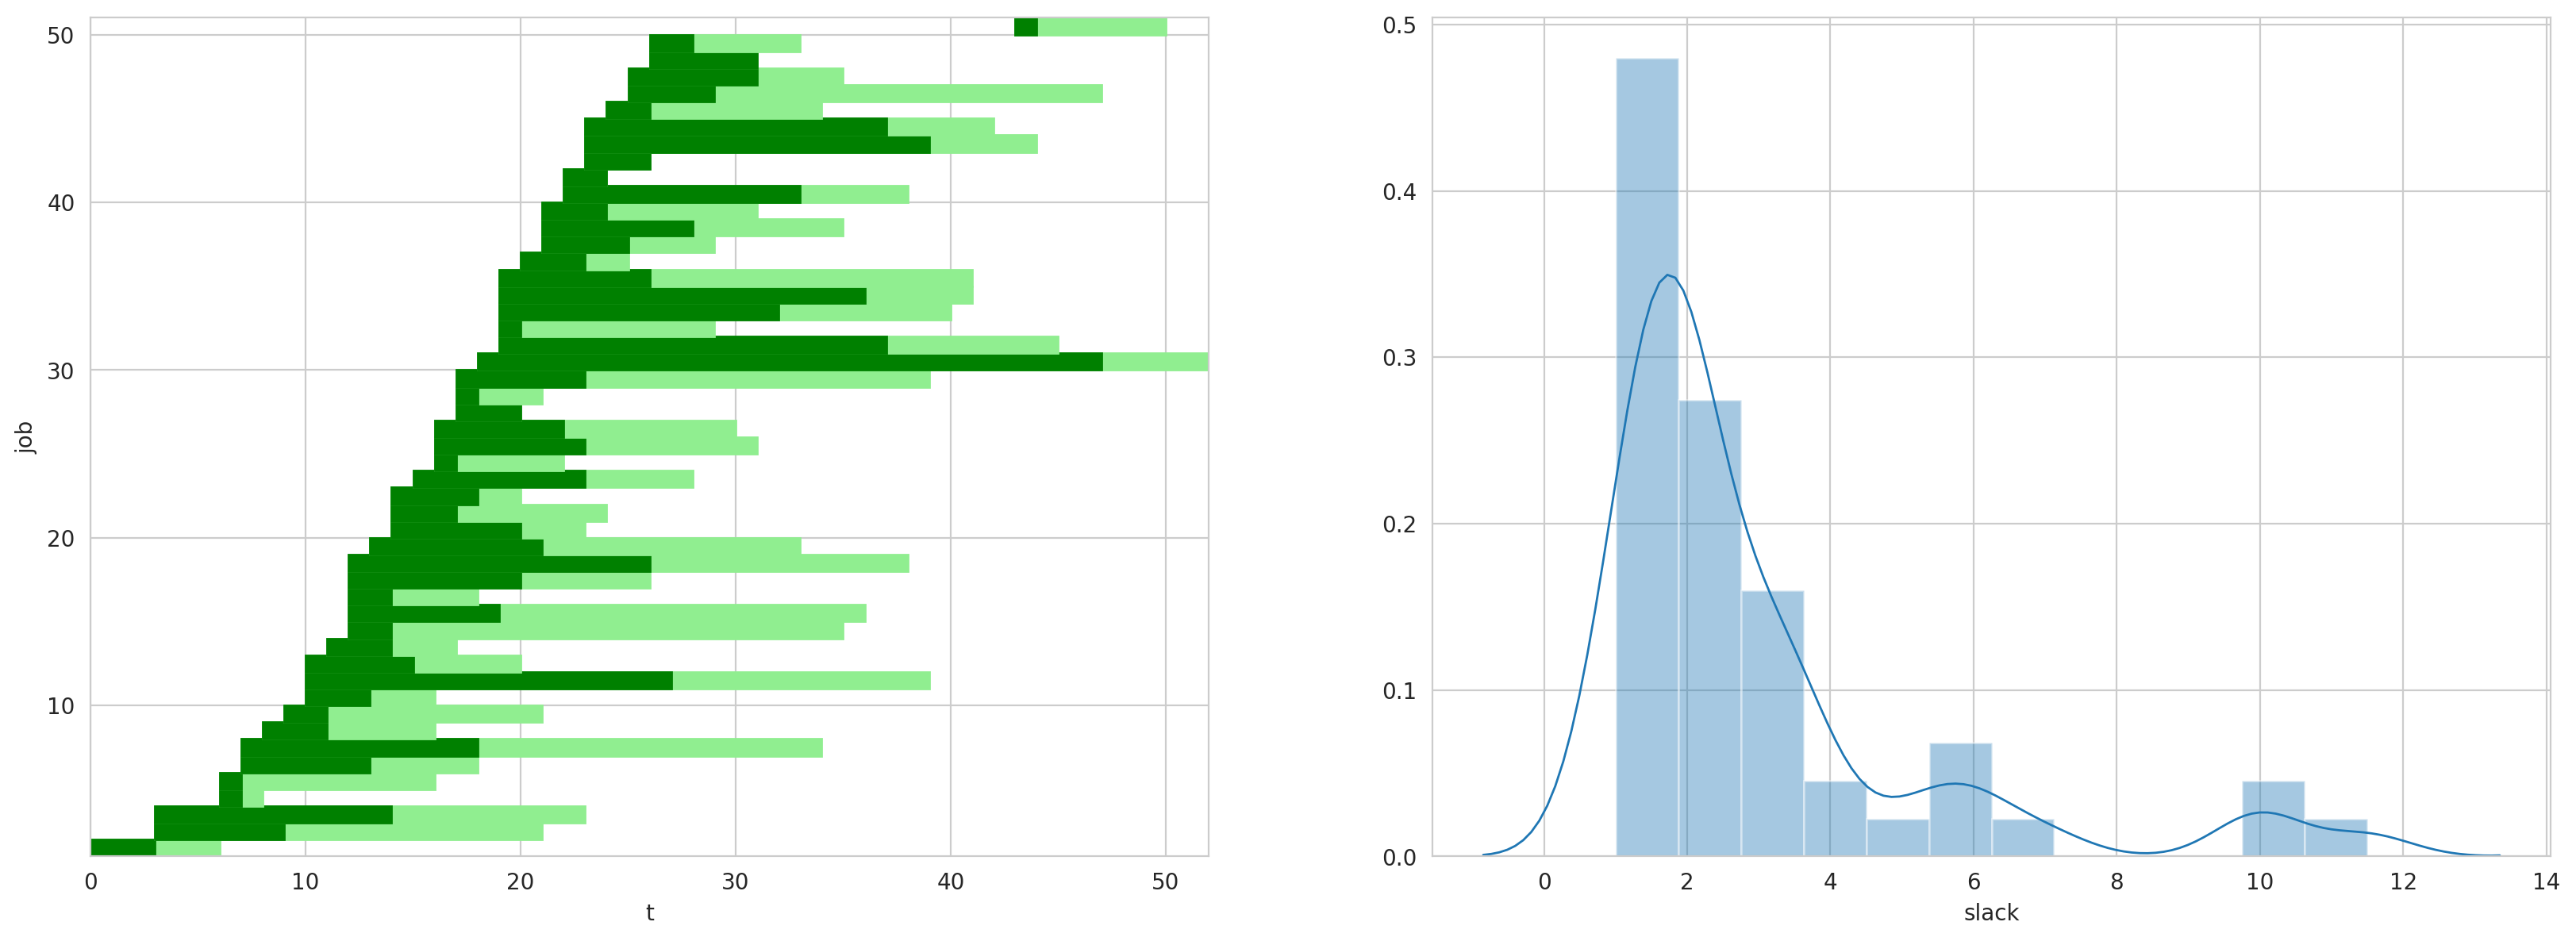

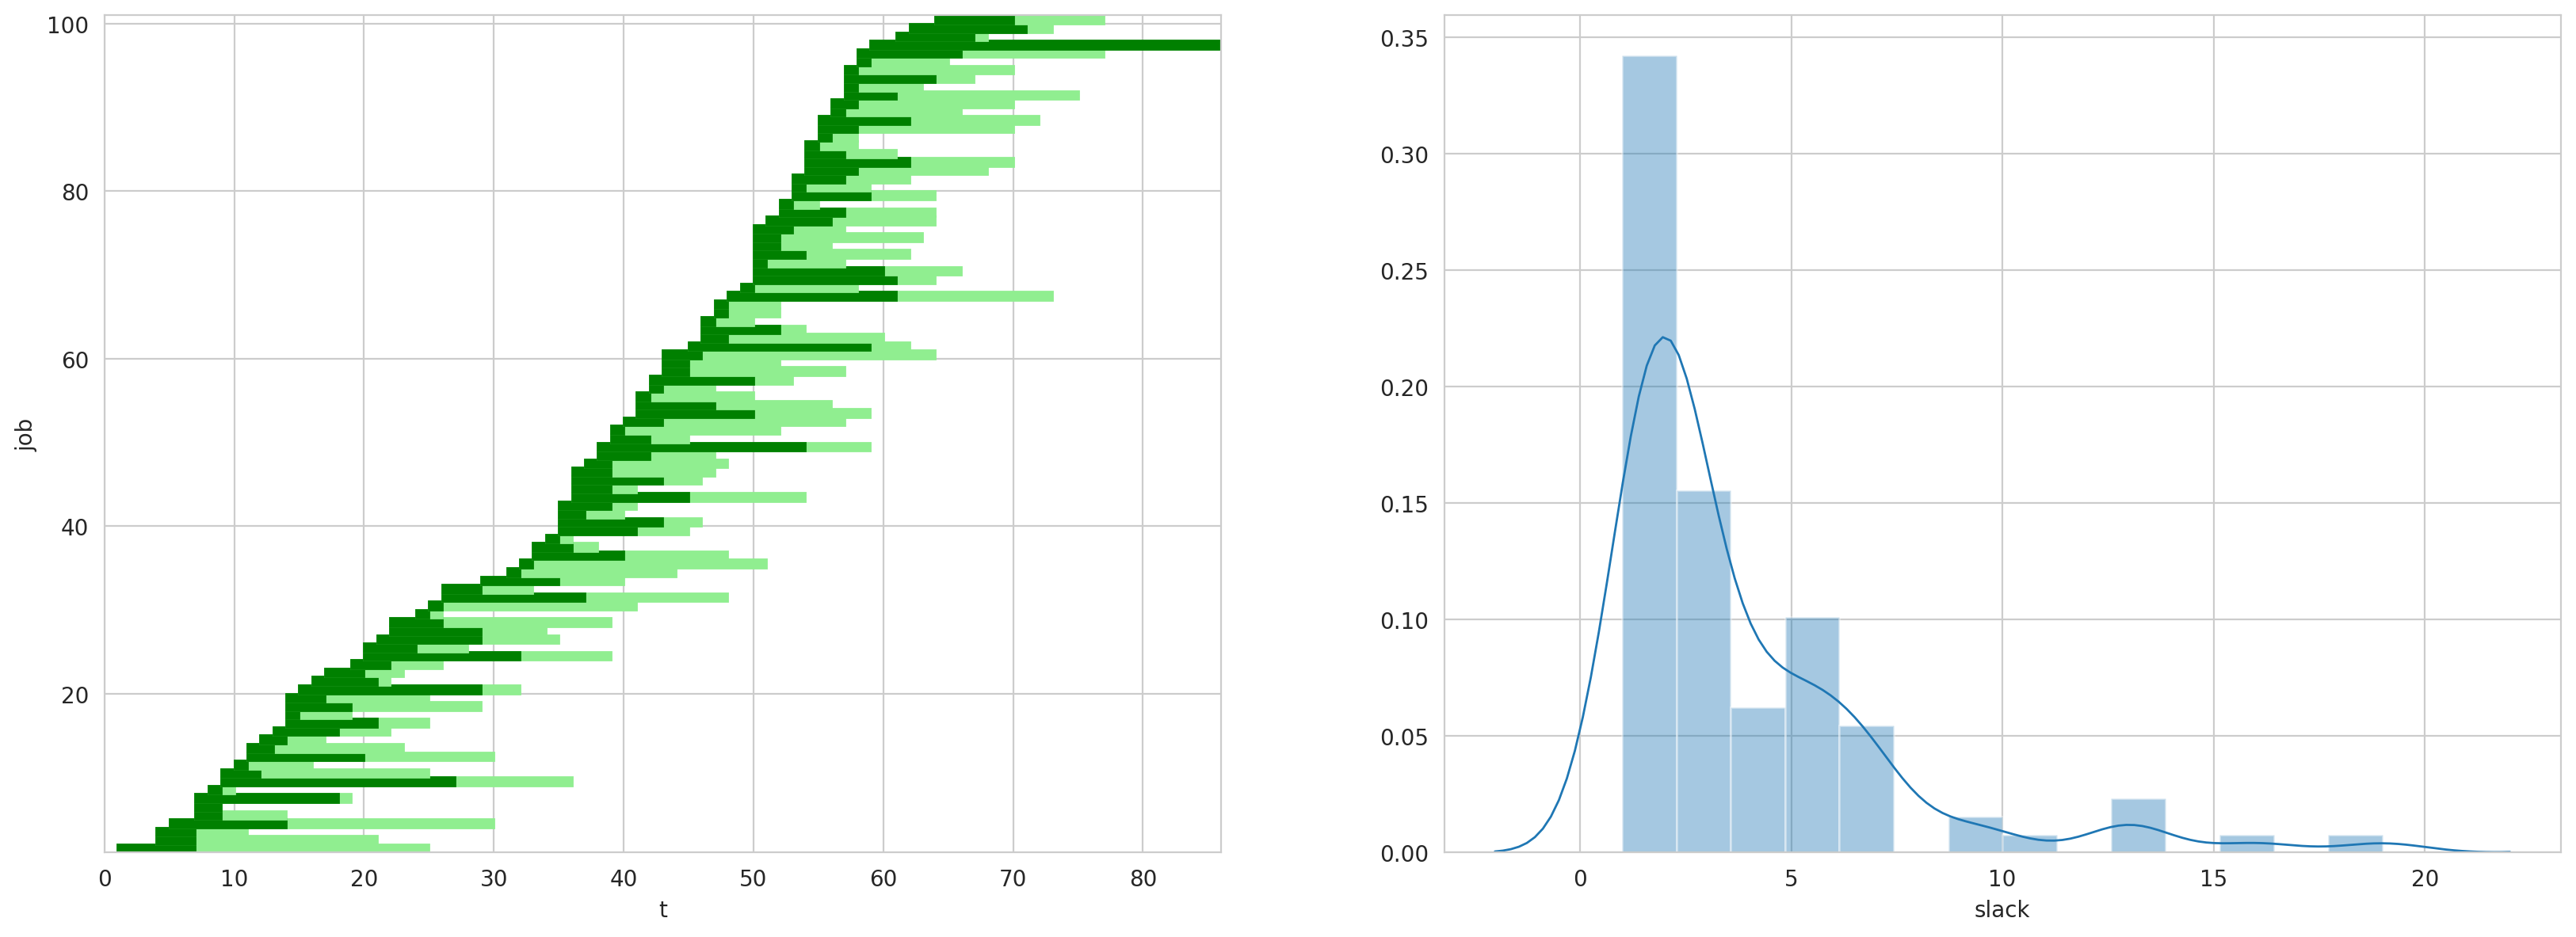

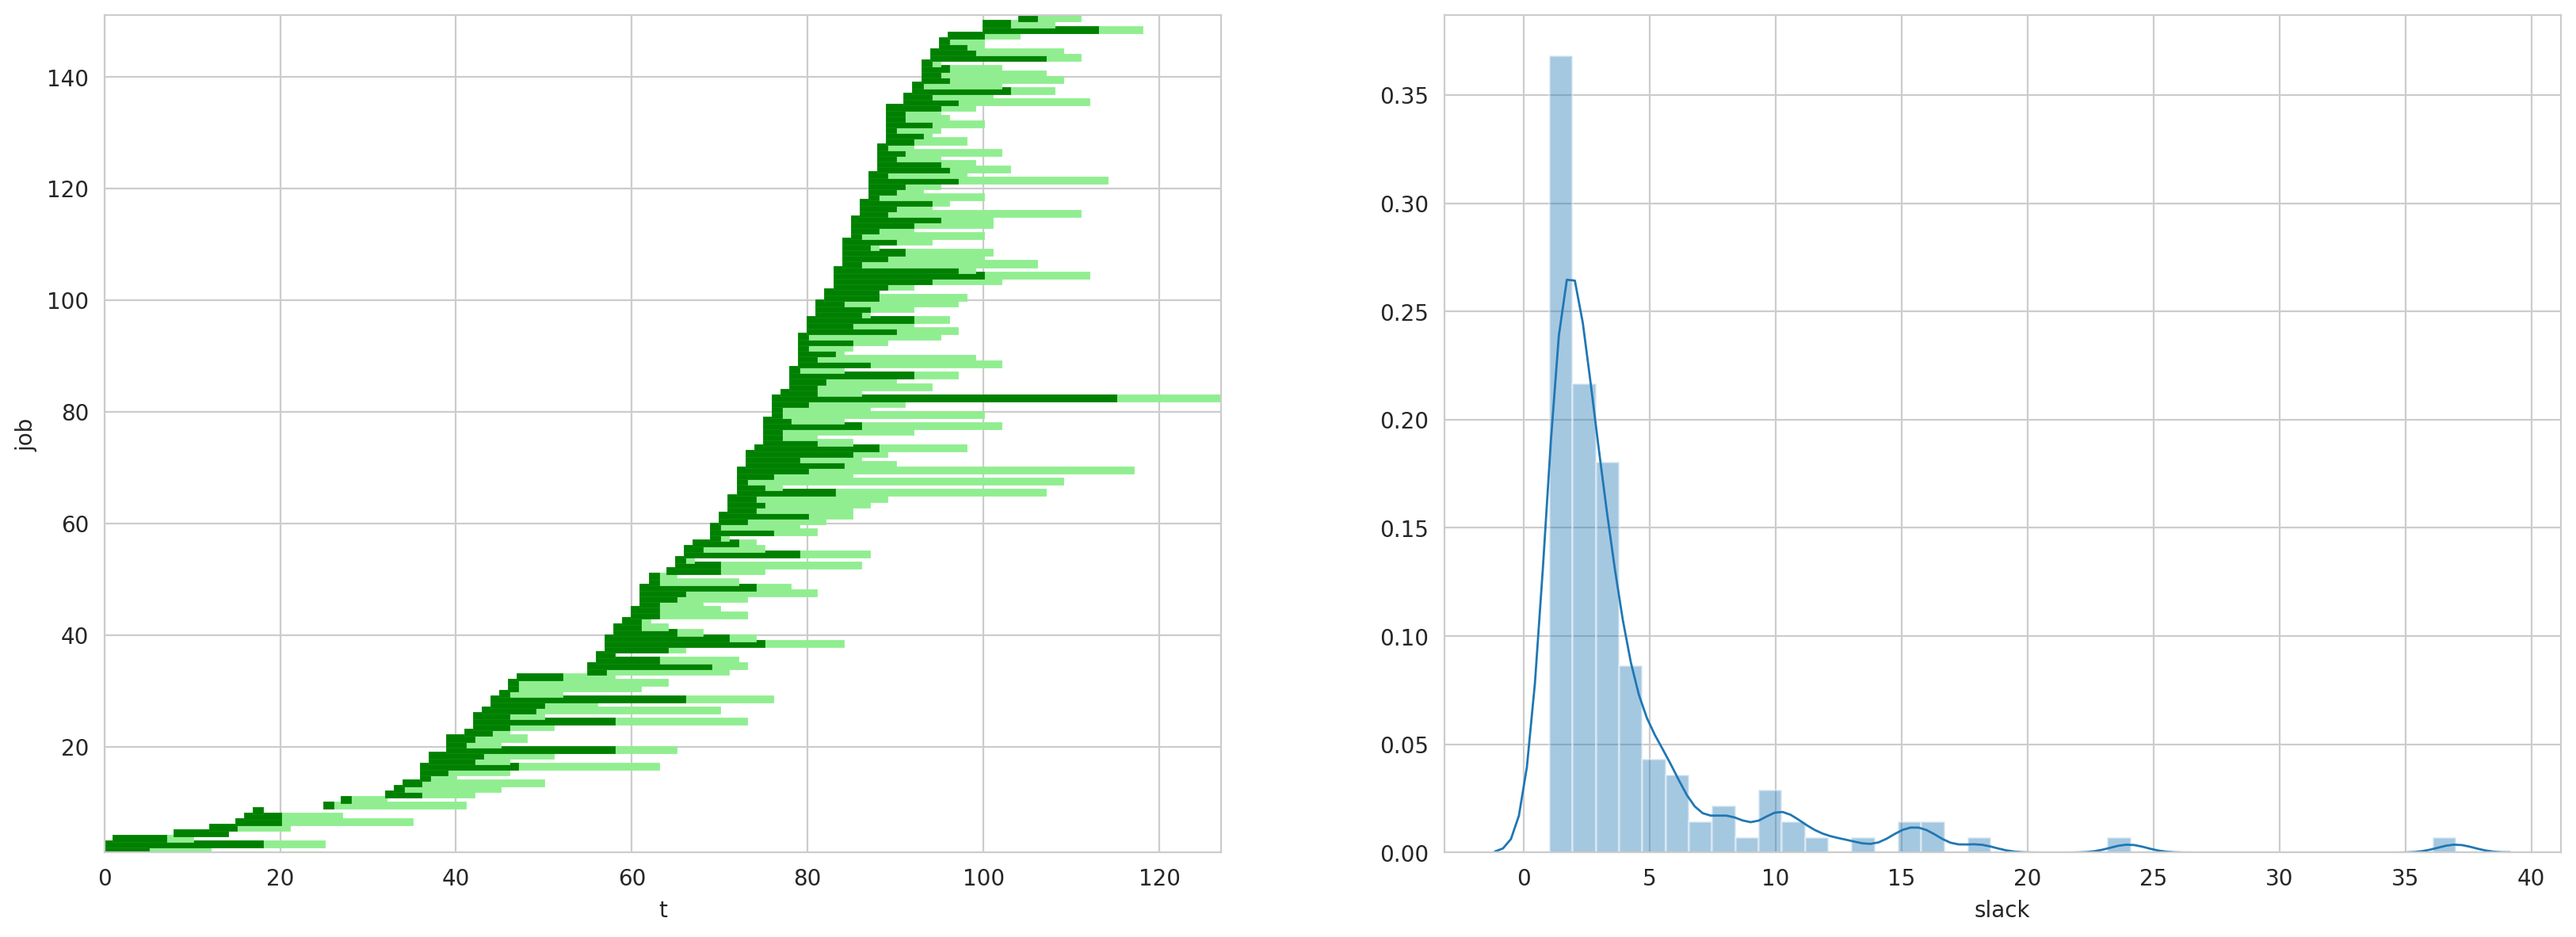

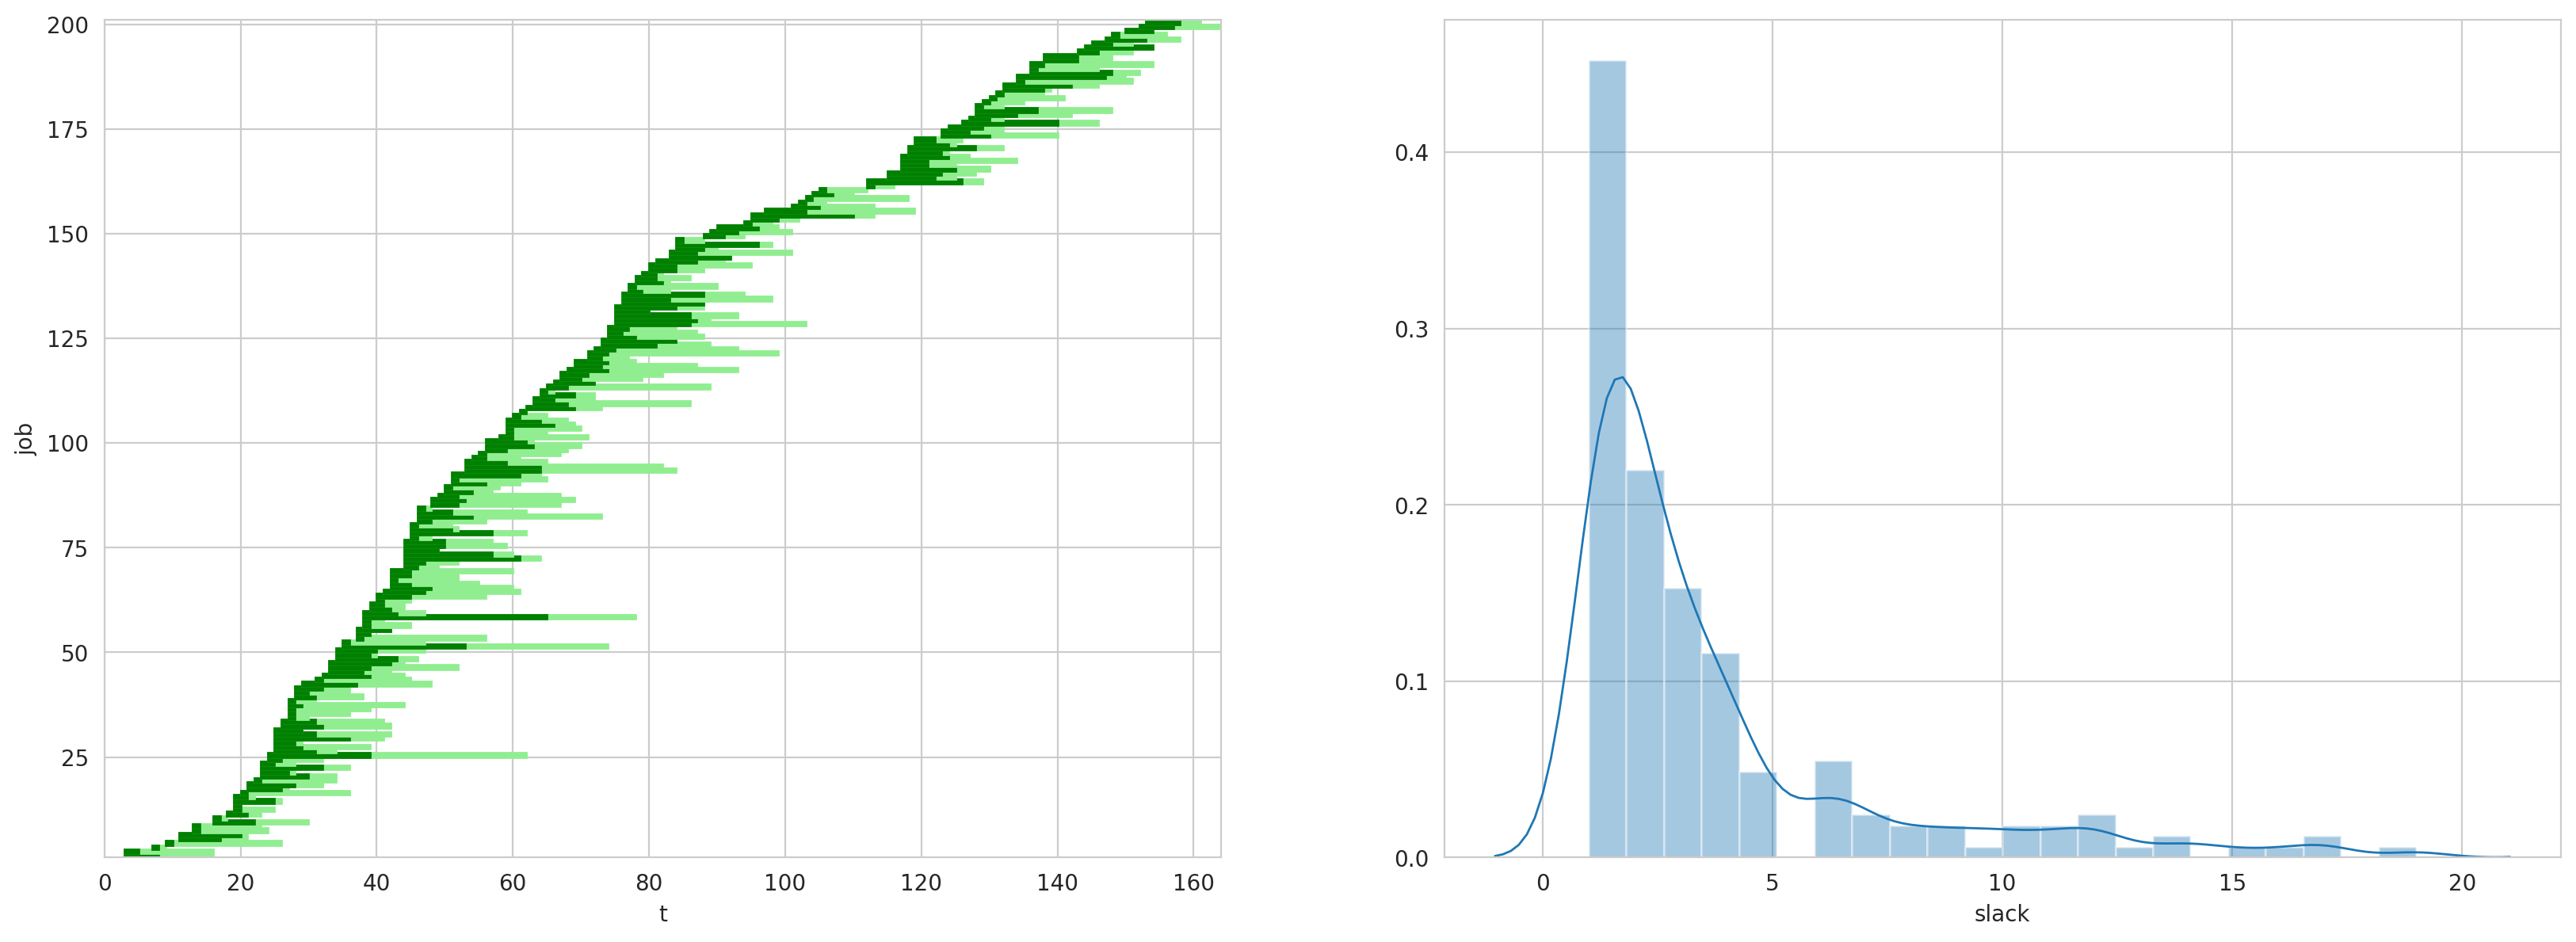

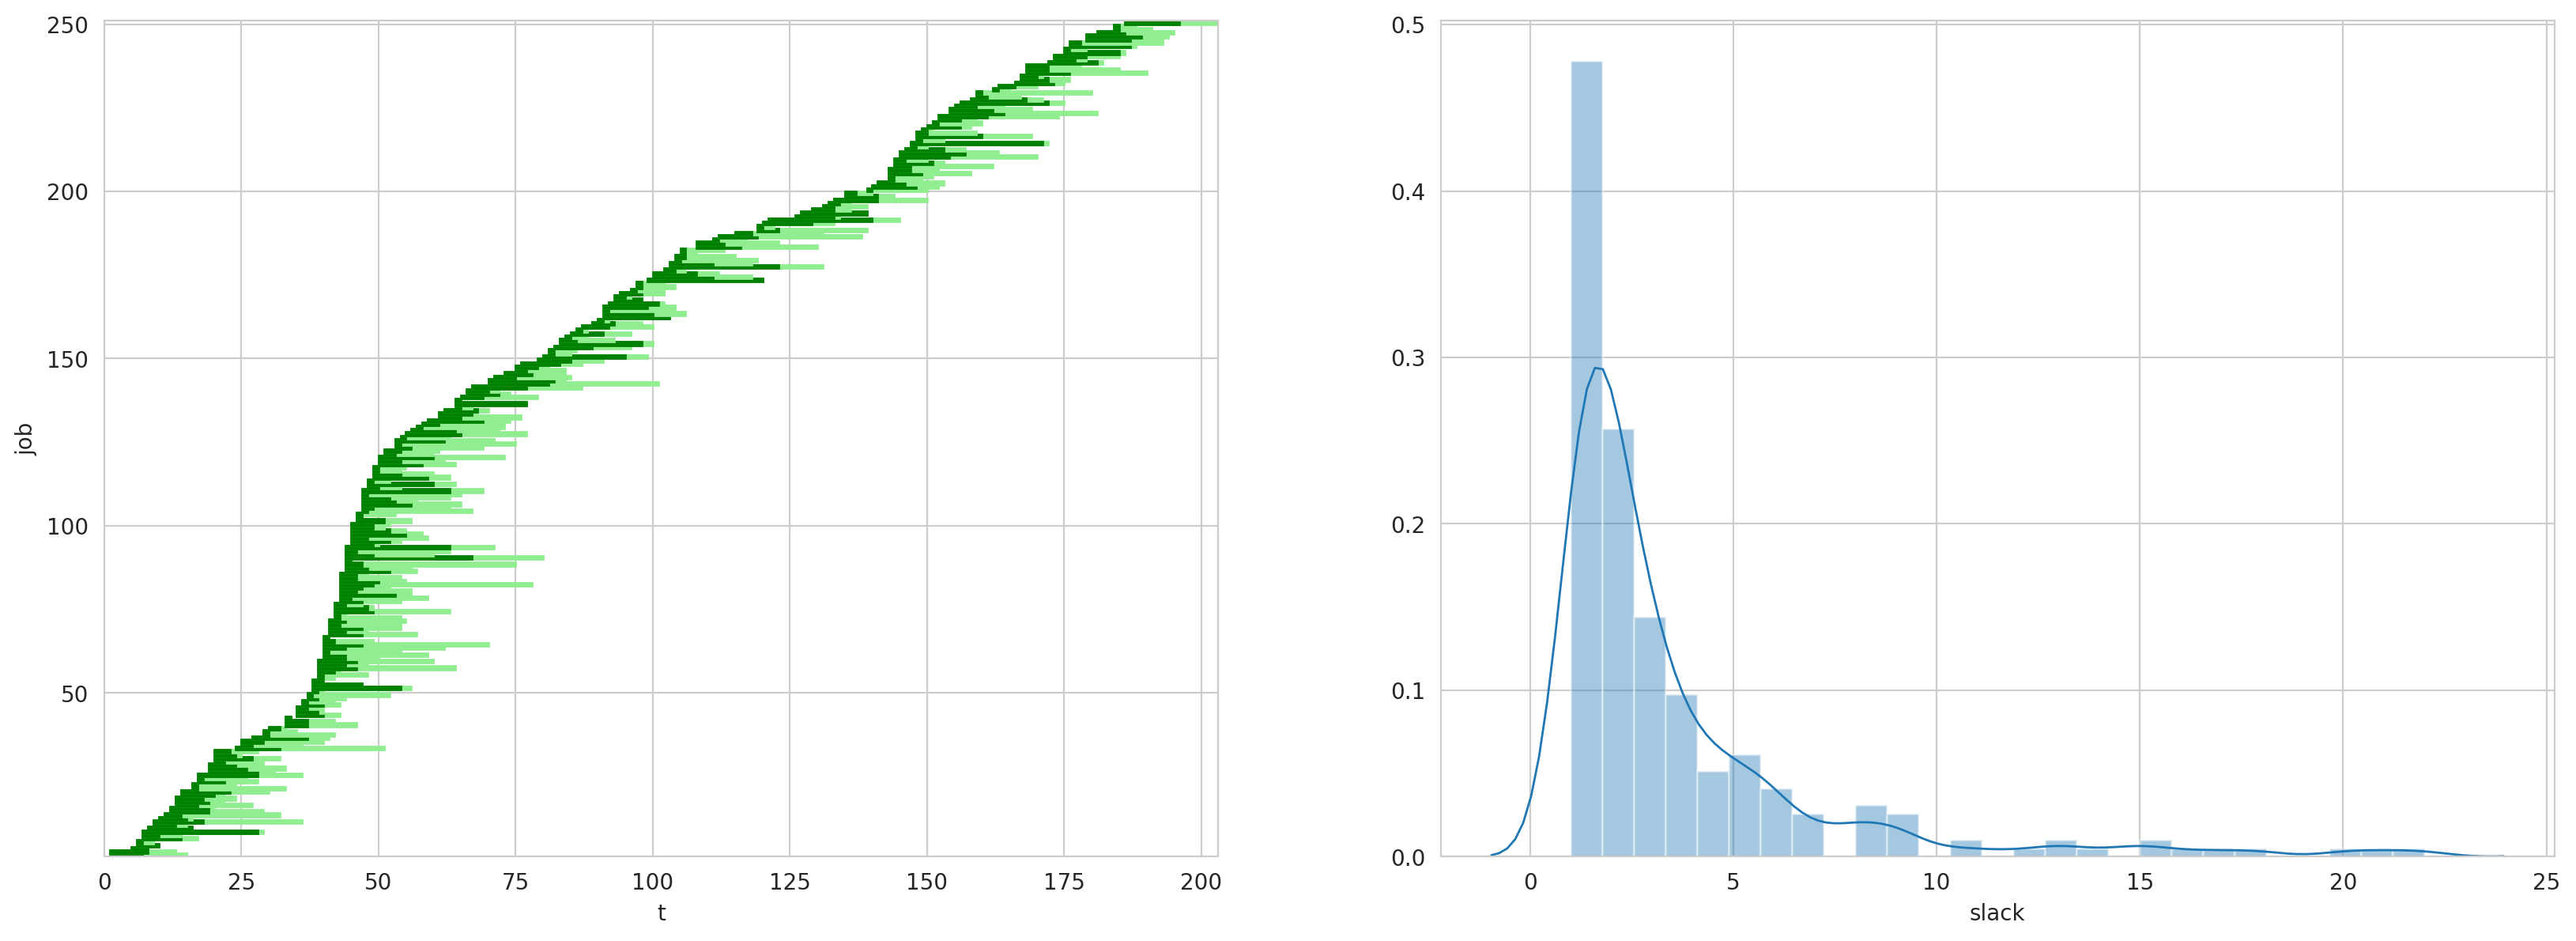

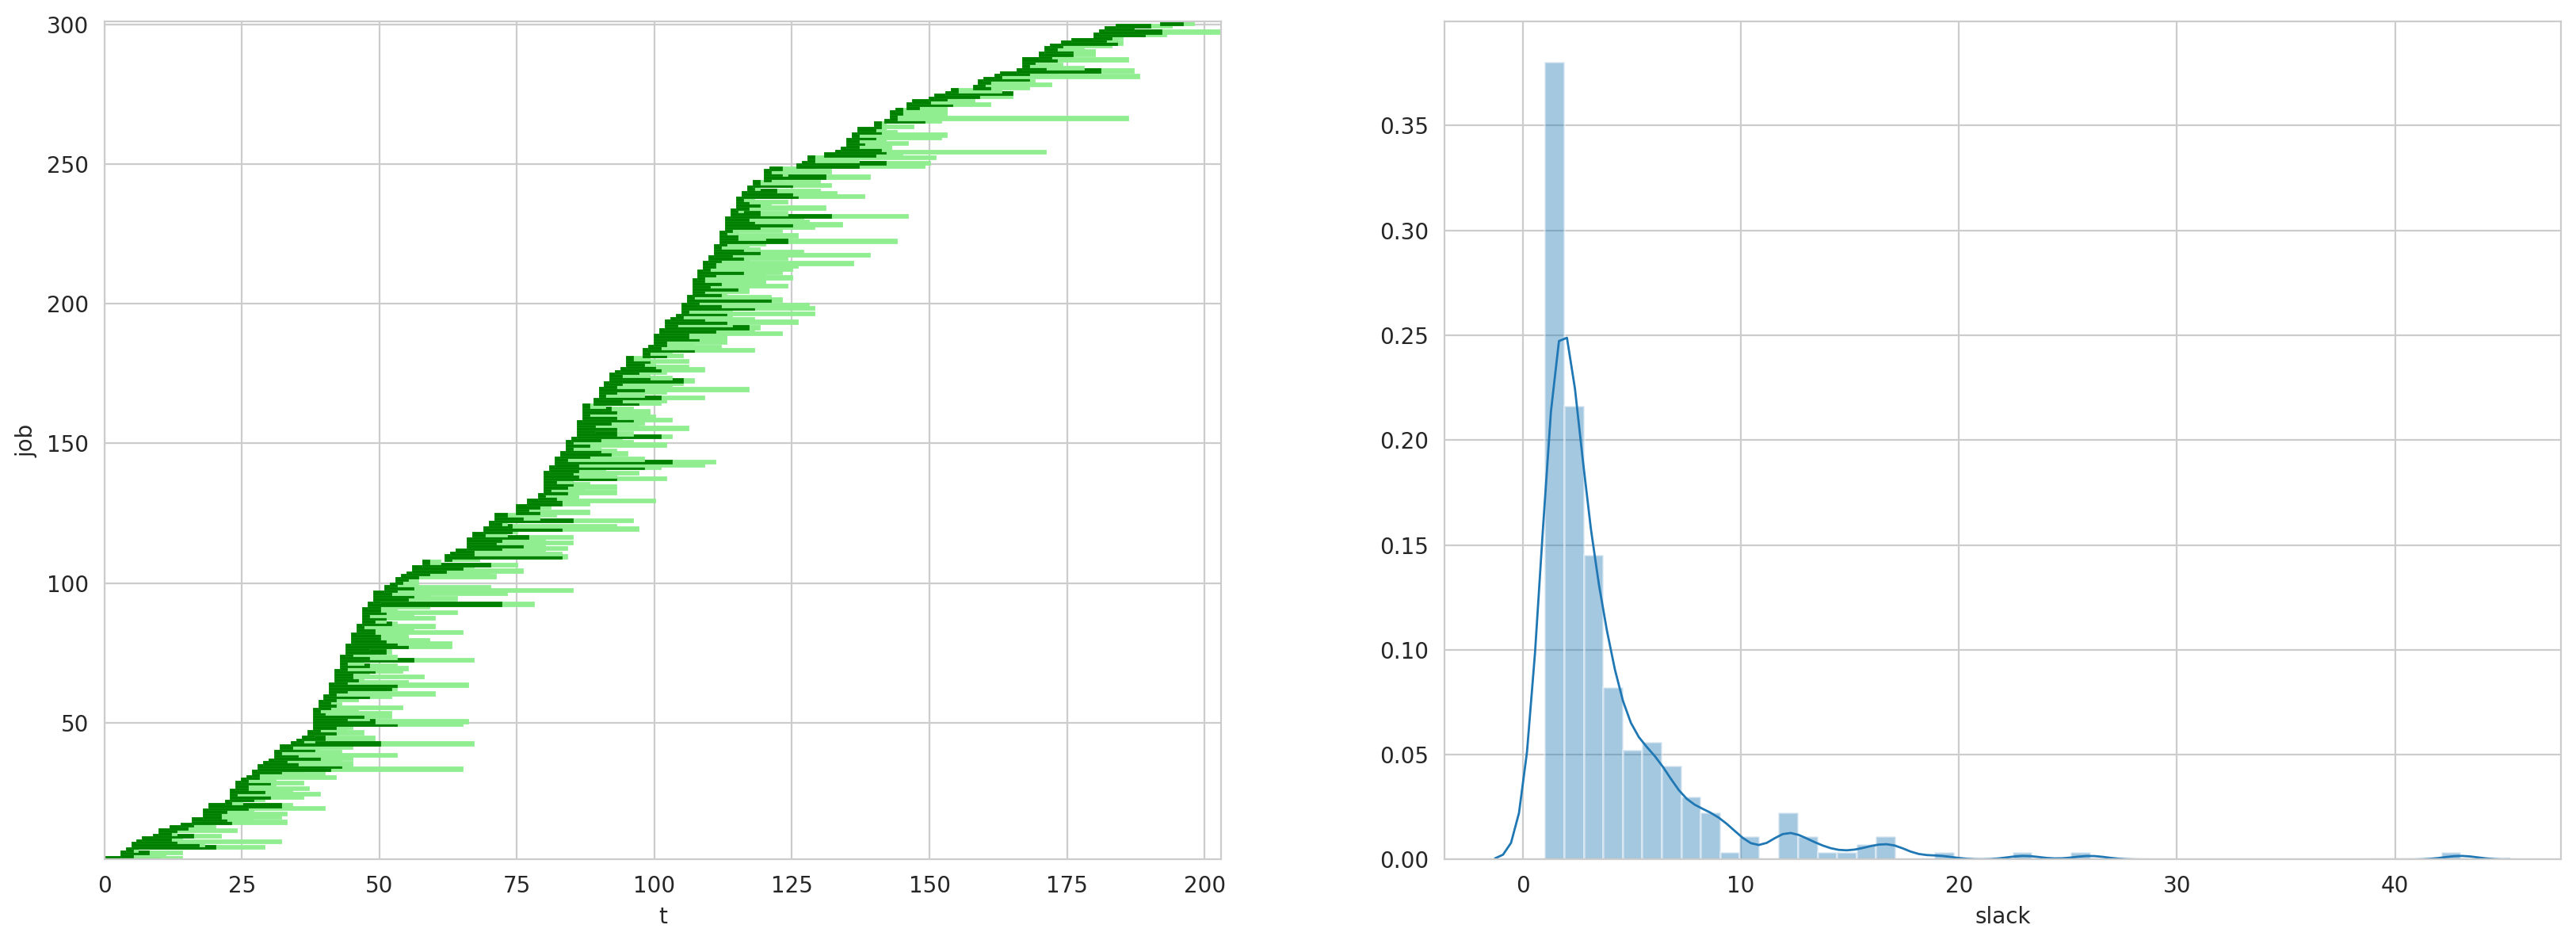

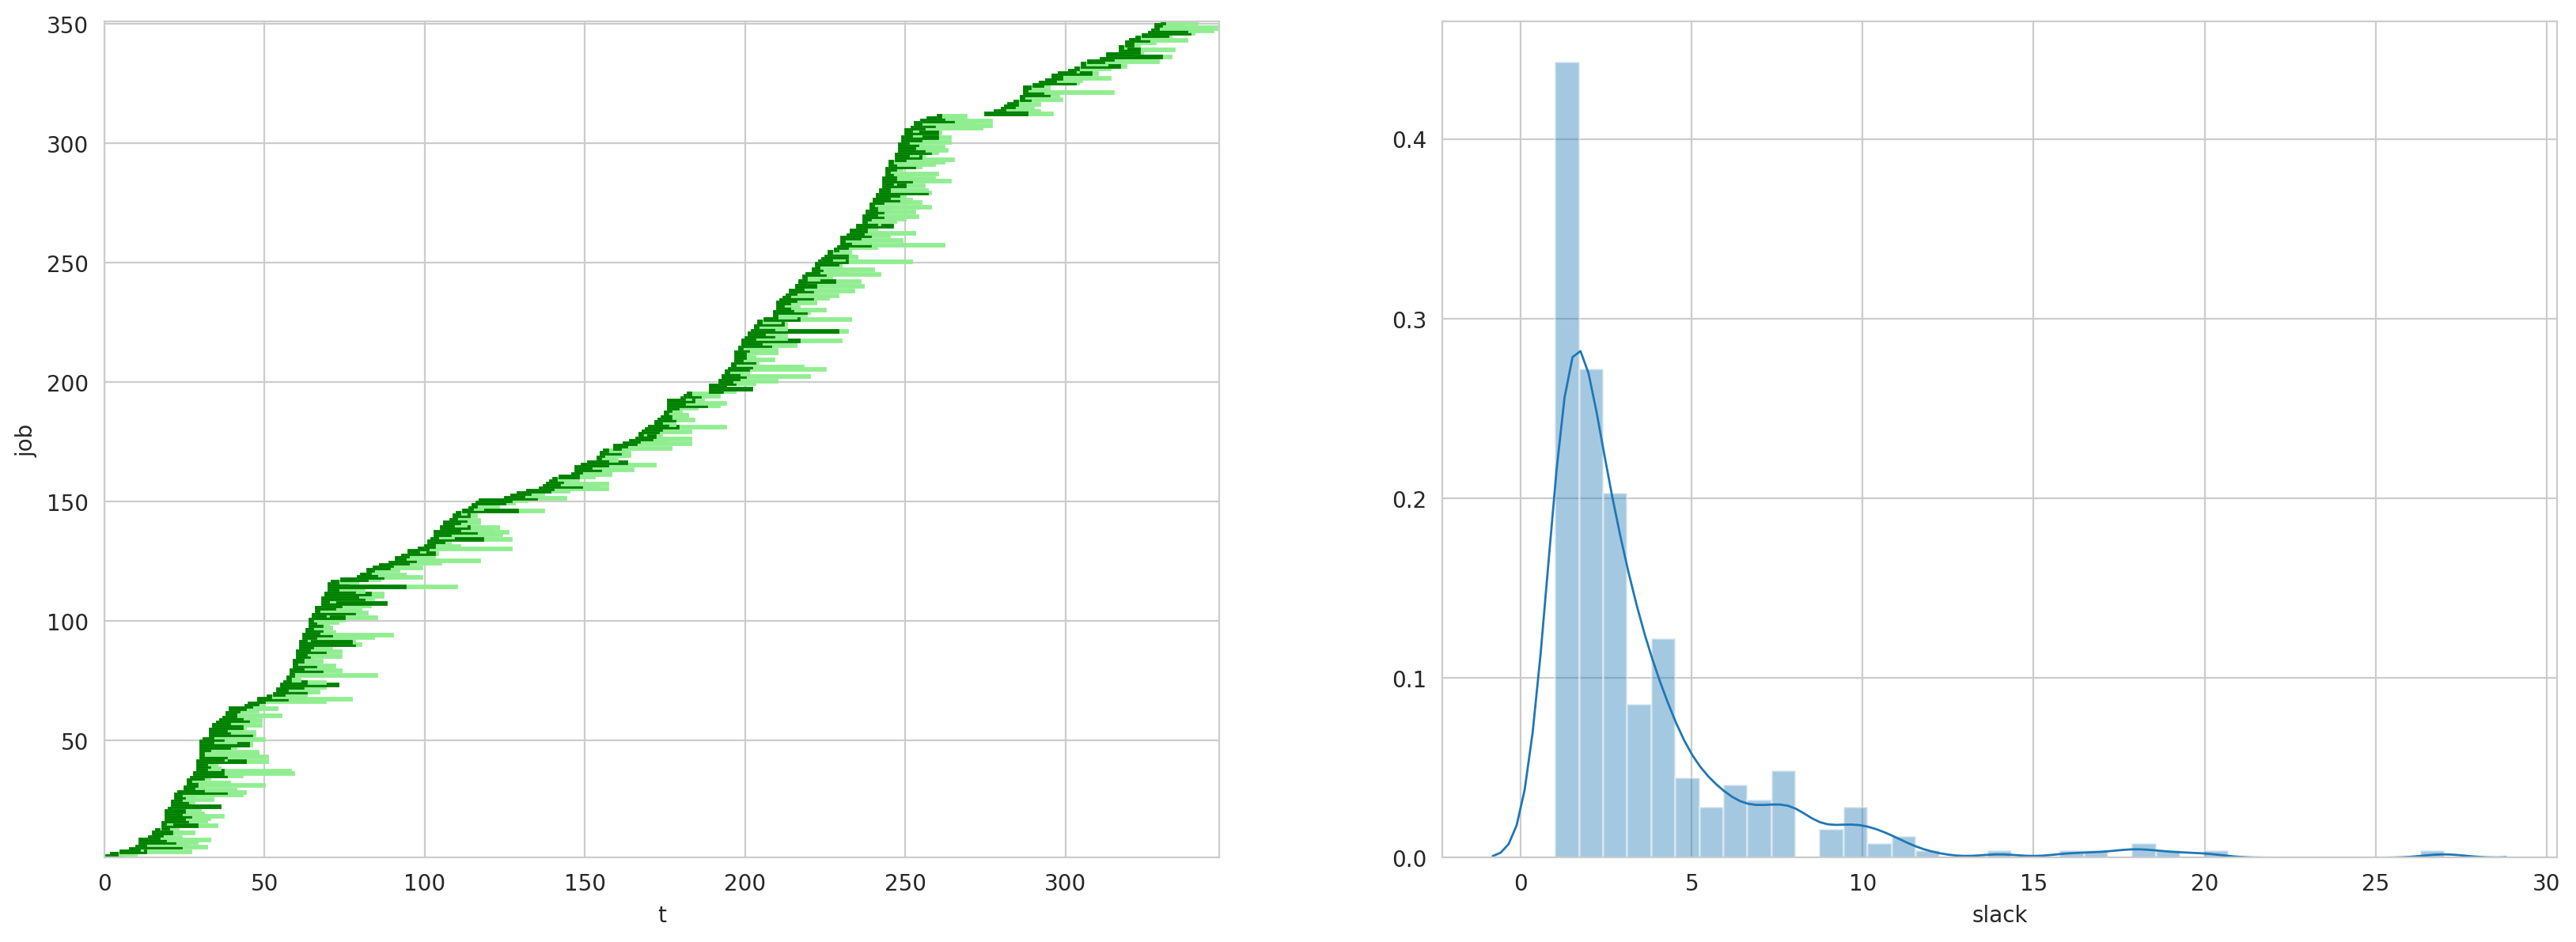

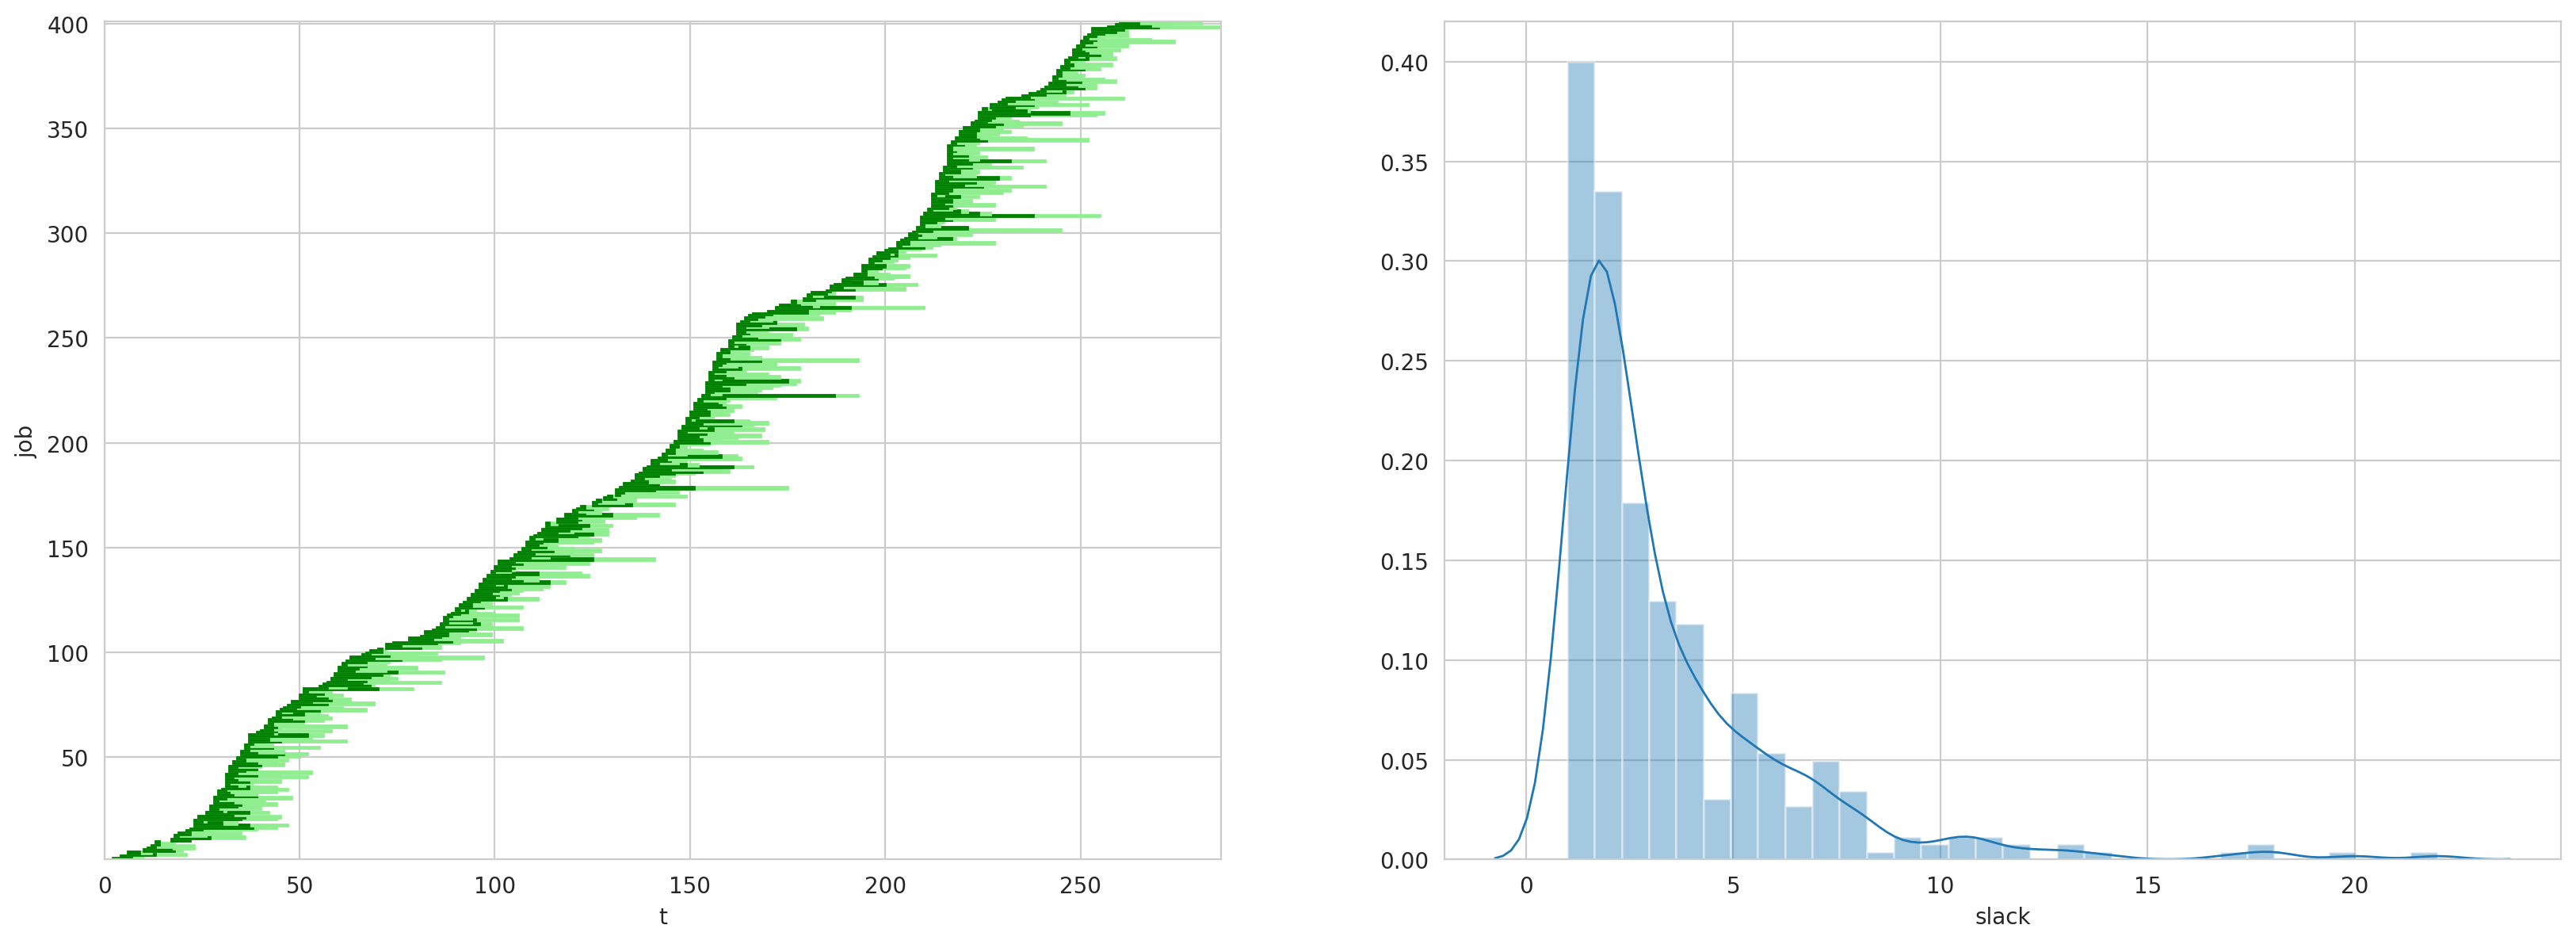

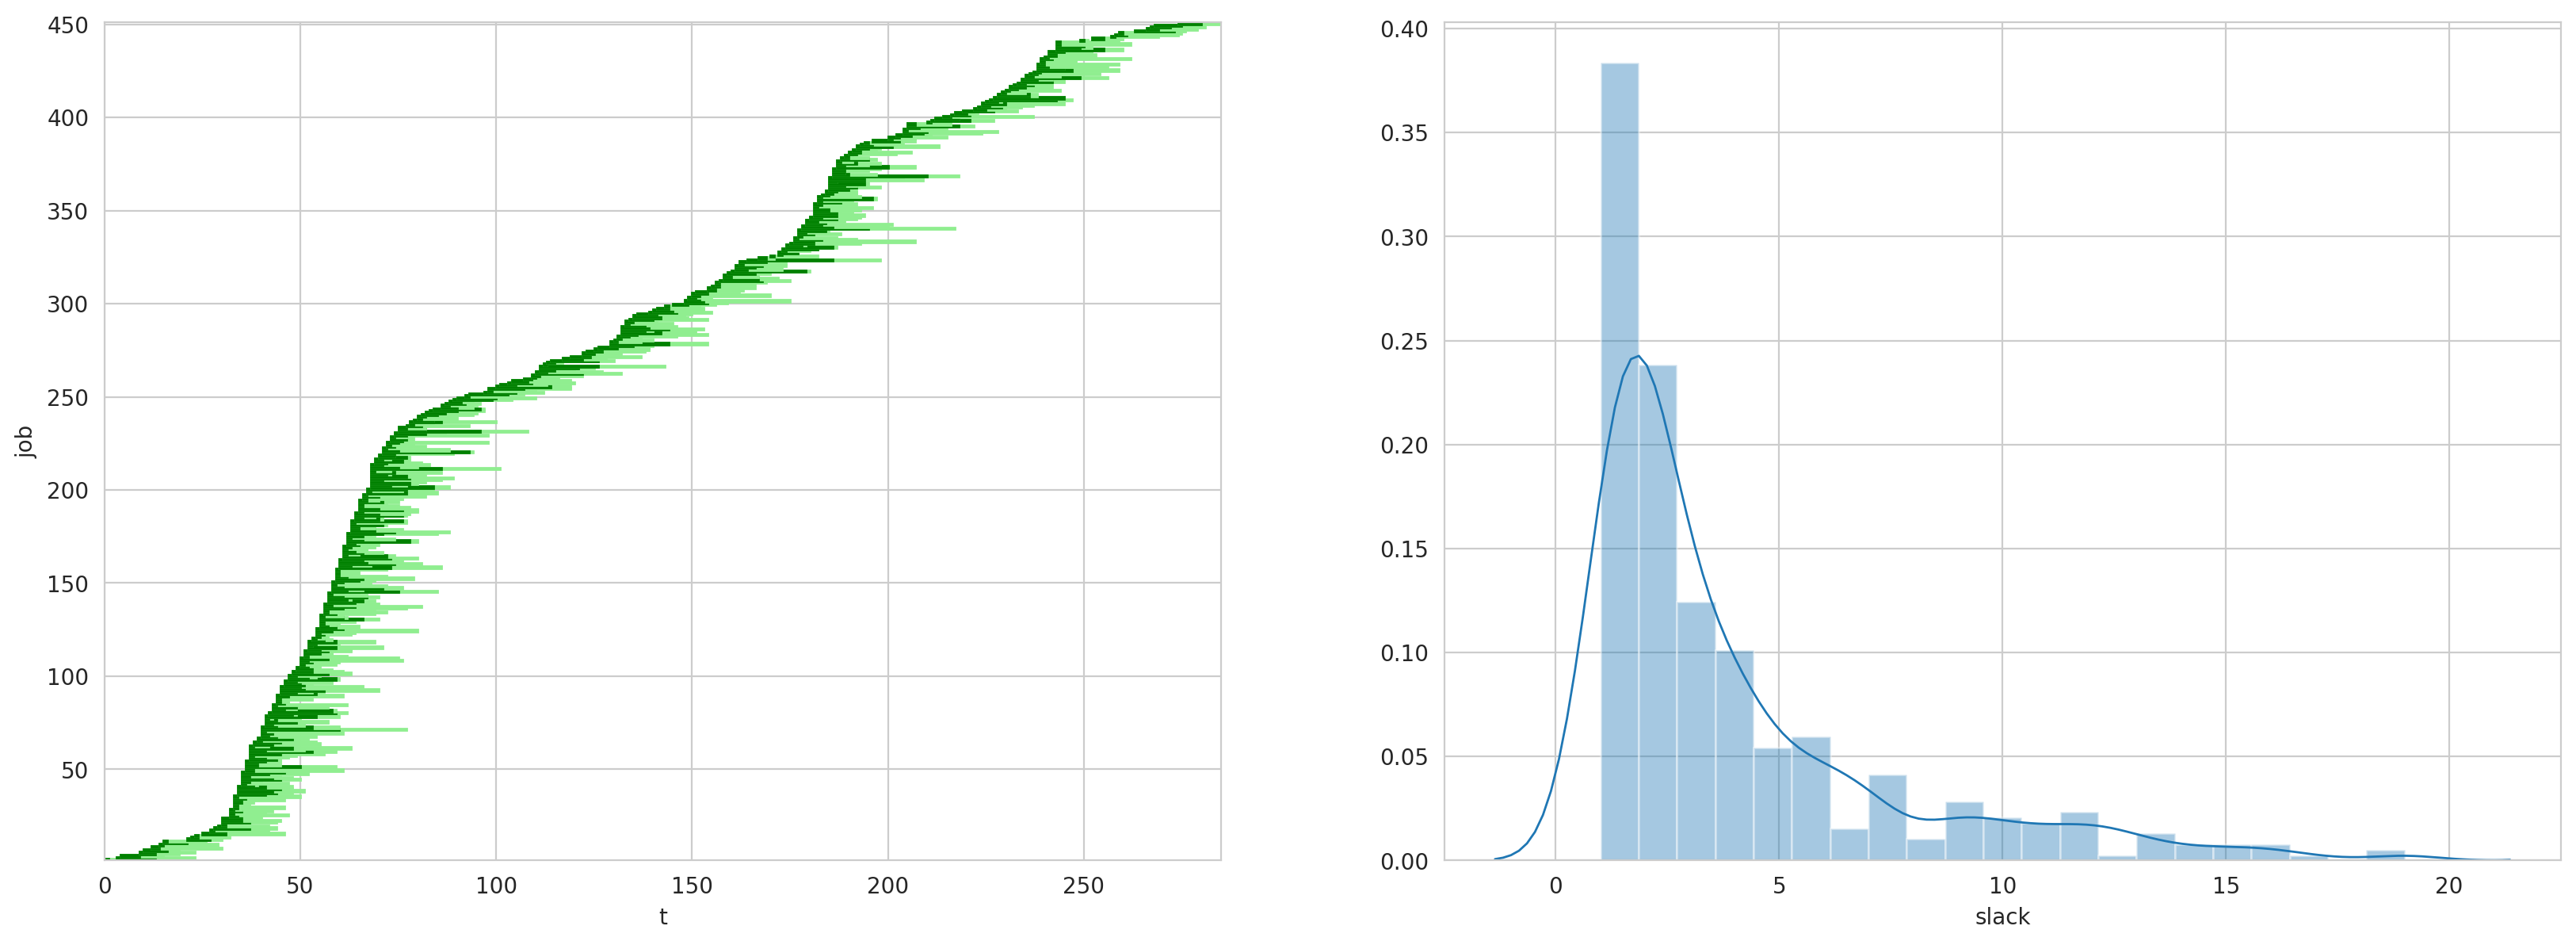

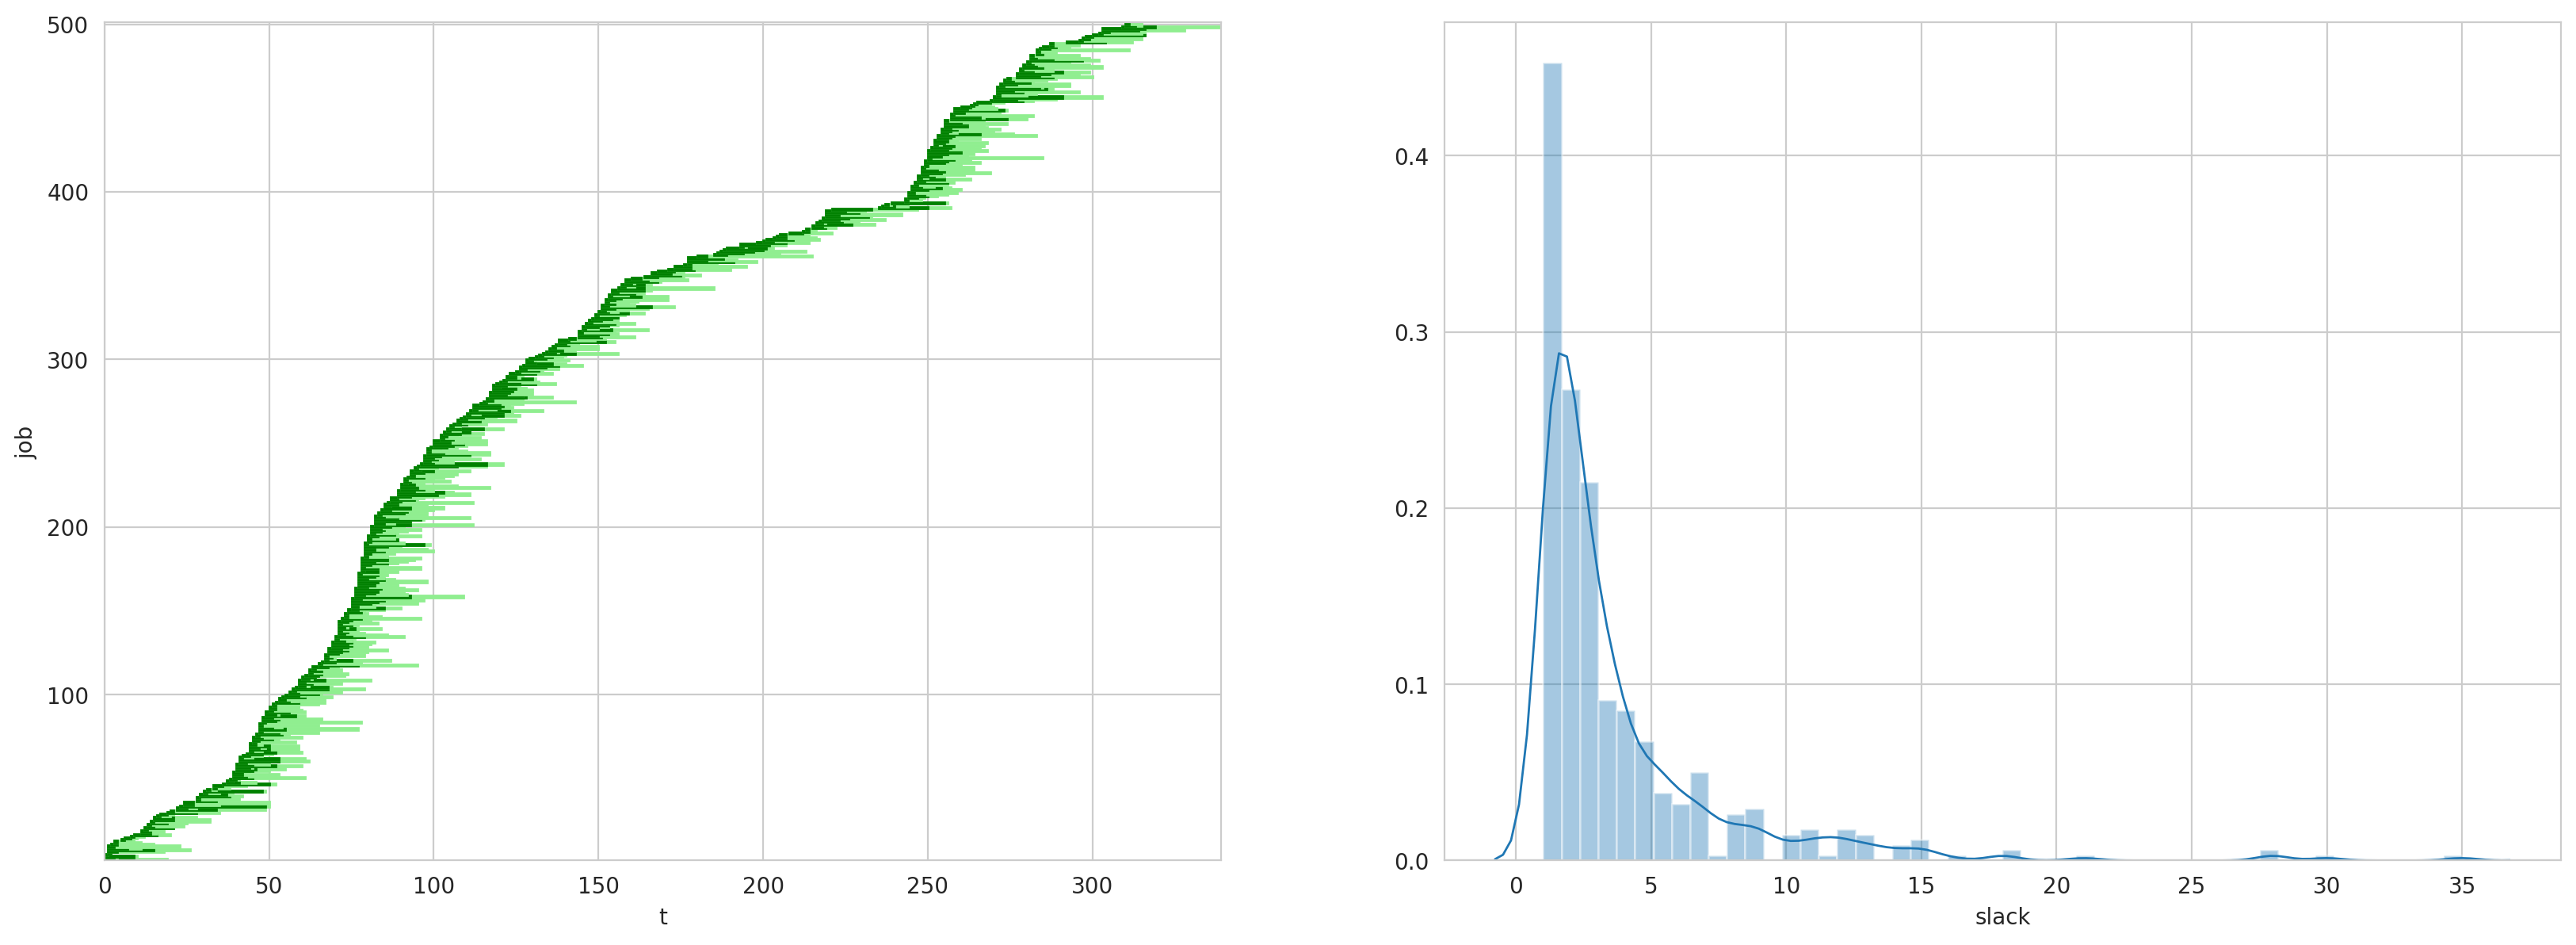

In [8]:
def plot_instance(path, shuffle=False):
    from validate import read_input
    P, R, D, W = read_input(path)
    N = len(P)
    #J = np.arange(N)
    J = np.argsort(R)
    #J, _ = solve(P, R, D, W)
    #if shuffle:
    #    np.random.shuffle(J)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(20, 7), dpi=200, ncols=2)
    h = 1
    t = 0
    for i, j in enumerate(J):
        p, r, d = P[j], R[j], D[j]
        y = (i+1) * h
        if t < r: t = r
        ax1.add_patch(patches.Rectangle((r, y), d - r, h, color='lightgreen'))
        ax1.add_patch(patches.Rectangle((r, y), p, h, color='green'))
        #ax1.add_patch(patches.Rectangle((t, y), p, h, color='red'))
        t += p
        
    ax1.set_ylim(1, N*h + 1)
    ax1.set_xlim(0, np.max(D))
    #ax1.set_xlim(0, t)
    ax1.set_ylabel('job')
    ax1.set_xlabel('t')
    
    S = (D - R) / P
    sns.distplot(S, ax=ax2)
    ax2.set_xlabel('slack')
    
    plt.show()

#plot_instance('ptsz_mm/in/136760/136760_100.txt')
#for i in [50, 250, 500]:
index = '136674'
for i in range(50, 550, 50):
    plot_instance(f'../in/{index}/{index}_{i}.txt', shuffle=False)

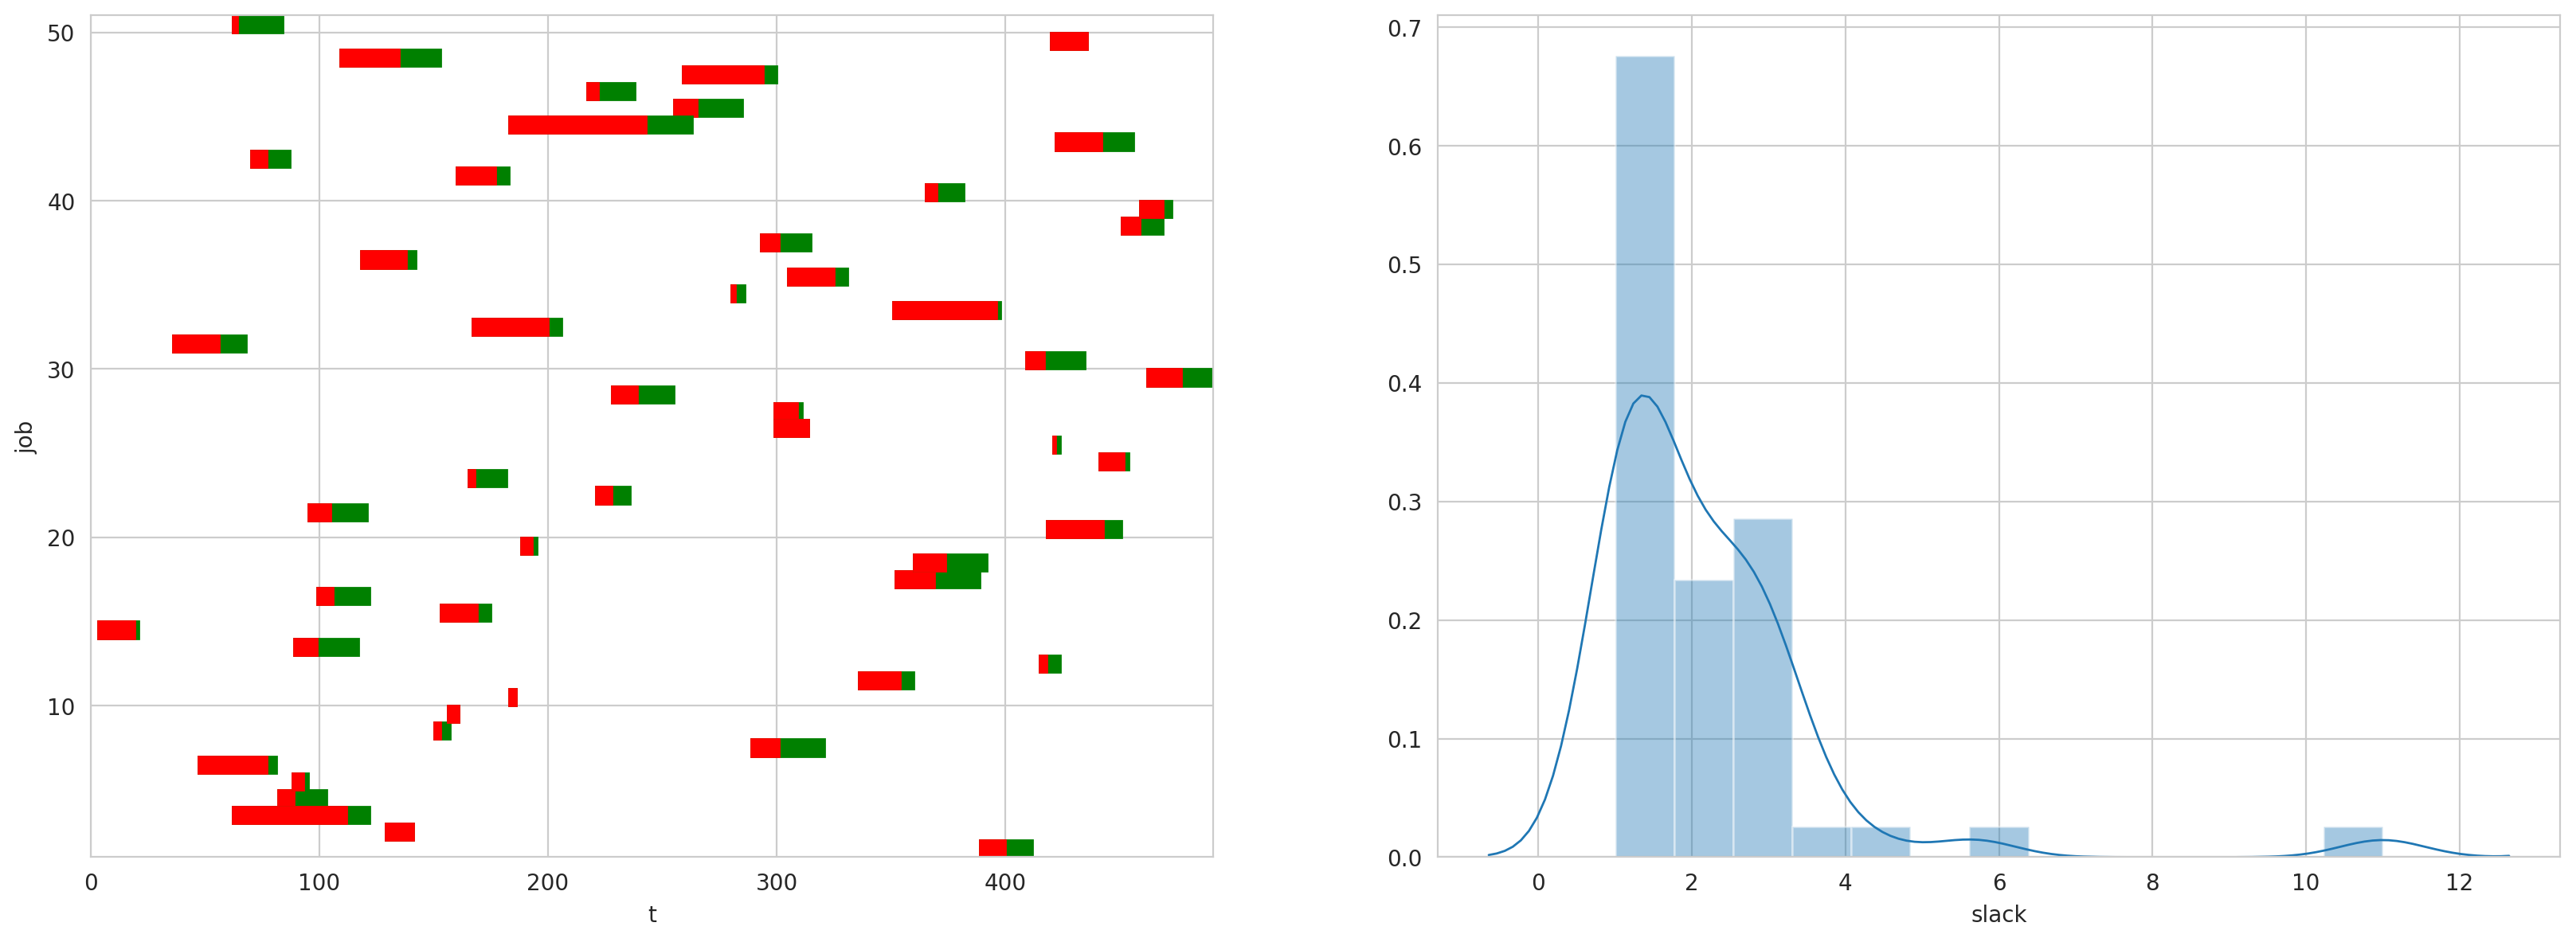

In [357]:
def plot_instance(path, shuffle=False):
    from zadanie1 import read_input
    P, R, D, W = read_input(path)
    N = len(P)
    #J = np.arange(N)
    #J = np.argsort(R)
    J, _ = solve(P, R, D, W)
    #if shuffle:
    #    np.random.shuffle(J)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(20, 7), dpi=200, ncols=2)
    h = 1
    t = 0
    for i, j in enumerate(J):
        p, r, d = P[j], R[j], D[j]
        y = (j+1) * h
        if t < r: t = r
        ax1.add_patch(patches.Rectangle((r, y), d - r, h, color='g'))
        ax1.add_patch(patches.Rectangle((r, y), p, h, color='r'))
        t += p
        
    ax1.set_ylim(1, N*h + 1)
    ax1.set_xlim(0, np.max(D))
    #ax1.set_xlim(0, t)
    ax1.set_ylabel('job')
    ax1.set_xlabel('t')
    
    S = (D - R) / P
    sns.distplot(S, ax=ax2)
    ax2.set_xlabel('slack')
    
    plt.show()

#plot_instance('ptsz_mm/in/136760/136760_100.txt')
#for i in [50, 250, 500]:
for i in range(50, 100, 50):
    plot_instance(f'ptsz_mm/in/{index}/{index}_{i}.txt', shuffle=False)